## Note: This notebook tries to calculate per-day Promo2 for each store. ##

In [196]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
import random
import operator
import datetime
import time

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn import datasets, linear_model, cross_validation, grid_search, svm, ensemble, kernel_ridge

In [2]:
np.random.seed(10)
random.seed(10)

In [3]:
def rmspe(y, yhat):
    y = y.astype('float')
    yhat = yhat.astype('float')
    inner = ((y-yhat)/y)**2
    return (np.mean(inner))**0.5

In [132]:
# get rossmann, store, & test csv files as a DataFrame
train_df  = pd.read_csv("train.csv", parse_dates = ['Date']) 
store_df     = pd.read_csv("store.csv")
test_df      = pd.read_csv("test.csv", parse_dates = ['Date'])

### Data Preprocessing ###

In [133]:
def getPromo2FirstDate(row):
    if row['Promo2'] == 1:
        startDate = np.datetime64("{0}-{1:02d}-{2:02d}".format(int(row['Promo2SinceYear']), 1, 1)) + \
            np.timedelta64(int(row['Promo2SinceWeek']) - 1, 'W')
    else:
        startDate = np.NaN
        
    return startDate

store_df['Promo2StartDate'] = store_df.apply(lambda row: getPromo2FirstDate(row),axis=1)

In [134]:
def calStorePromo2Bitmask(row):
    val = 0
    
    if row['Promo2'] != 1:
        return 0
    
    promoInterval = row['PromoInterval']    
    for i in range(1,13):
        month = datetime.date(2008, i, 1).strftime('%b')
        # 'Promo2' is 0 or 1.  We use this and the "month in str(x)" to check if the store runs Promo2 in that month
        if month in promoInterval:
            val += 2**i
    
    return val

store_df['Promo2MonthBitmask'] = store_df.apply(lambda row: calStorePromo2Bitmask(row), axis=1 )


In [135]:
# Got a warning about column 7 during import.
# Fix it by change all 0 to '0'
train_df.loc[train_df['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Keep only records where the store is open
train_df = train_df[train_df['Open'] == 1]

# Keep only records with non-zero sales
train_df = train_df[train_df['Sales'] > 0]

In [223]:
def isPromo2(row):
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

    if row['Promo2'] == 0 or row['Promo2'] is None:
        return 0
    
    if row['Date'] < row['Promo2StartDate']:
        return 0
    
    if monthDict[row['Month']] in row['PromoInterval']:
        return 1

def convertColToCategory(data, colName, cat):
    data.loc[:, colName] = data.loc[:, colName].astype('category', categories=cat)


def transformData(inputData, isTrainData = True):

    data = inputData.copy()

    # Add month and year columns
    data.loc[:, ('Month')] = data['Date'].dt.month
    data.loc[:, ('Year')] = data['Date'].dt.year
    
    data['IsPromo2Day'] = np.bitwise_and(data['Promo2MonthBitmask'], 2 ** data['Month']) != 0

    # For the dates which is before Promo2StartDate, set IsPromo2Day to zero.
    data['IsPromo2Day'] = np.logical_and(data['IsPromo2Day'], data['Date'] >= data['Promo2StartDate'])
    data['IsPromo2Day'] = data['IsPromo2Day'].astype('int')
    
    # Convert categorical columns to category type
    # Need to specify the categories explicitly because in the test dataframe, not all categories
    # (e.g. January) is there.
    convertColToCategory(data, 'DayOfWeek', range(1, 8))
    convertColToCategory(data, 'Month', range(1, 13))
    convertColToCategory(data, 'Year', range(2013, 2016))
    convertColToCategory(data, 'Promo', range(2))
    convertColToCategory(data, 'IsPromo2Day', range(2))
    
    # The columns to keep for training
    cols_to_keep = [u'Store', u'Date', u'SchoolHoliday',
       u'IsPromo2Day', u'DayOfWeek',
       u'Promo', u'StateHoliday', u'StoreType', u'Assortment', 
       u'Month', u'Year']
    
    if isTrainData:
        cols_to_keep.append(u'Sales')
    
    if not isTrainData:
        cols_to_keep.append('Id')
        cols_to_keep.append('Open') # During prediction, closed store will automatically get 0 sales
    
    data = data[cols_to_keep]
    
    return pd.get_dummies(data)

In [224]:
train_full_df = pd.merge(train_df, store_df, on='Store')
train_data = transformData(train_full_df)

In [225]:
test_full_df = pd.merge(test_df, store_df, on='Store')
test_data = transformData(test_full_df, isTrainData = False)

# Sort training data by date
train_data.set_index('Date', inplace=True)
train_data.sort_index(inplace=True)

In [235]:
def getXCols():
    # List the columns we need for training
    getCols = lambda prefix: [col for col in train_data.columns if prefix in col]
    
    cols = []
    #cols.extend(getCols('IsPromo2Day_'))
    cols.extend(getCols('DayOfWeek_'))
    cols.extend(getCols('Promo_'))
    cols.extend(getCols('Month_'))
    cols.extend(getCols('Year_'))
    
    return cols
    
x_cols = getXCols()

def trainModels(n_cutoff_months, algo, store=None, **kwargs):
    all_y = []
    all_yhat = []
    all_rmspe = {}
    models = {}
    
    startTime = time.time()
    
    if store is not None:
        data = train_data[train_data['Store'] == store]
    else:
        data = train_data

    test_cutoff_date = data.index.max() - pd.DateOffset(months = n_cutoff_months)

    train_set = data[data.index <= test_cutoff_date]
    dev_set = data[data.index > test_cutoff_date]
    print "train_set size:", len(train_set)
    print "dev_set size:", len(dev_set)

    
    train_set_grouped = train_set.groupby('Store')
    dev_set_grouped = dev_set.groupby('Store')
    cols = None
    
    for group in train_set_grouped.groups.keys():        
        train_X = train_set_grouped.get_group(group)[x_cols]
        train_y = np.log(train_set_grouped.get_group(group)['Sales'])

        dev_X = dev_set_grouped.get_group(group)[x_cols]
        dev_y = np.log(dev_set_grouped.get_group(group)['Sales'])

        # One model per store
        if algo == 'lr':
            model = linear_model.LinearRegression(**kwargs)
        elif algo == 'ridge':
            model = linear_model.Ridge(**kwargs)
        elif algo == 'svr':
            model = svm.SVR(**kwargs)
        elif algo == 'nsvr':
            model = svm.NuSVR(**kwargs)
        elif algo == 'rfr':
            model = ensemble.RandomForestRegressor(**kwargs)
        elif algo == 'kr':
            model = kernel_ridge.KernelRidge(**kwargs)
            
        model.fit(X=train_X, y=train_y)
        models[group] = model
        yhat = model.predict(dev_X)

        all_y.extend(dev_y.tolist())
        all_yhat.extend(yhat.tolist())
        
        all_rmspe[group] = rmspe(np.exp(np.array(dev_y.tolist())), np.exp(yhat))
        
    print "Training model - dev data RMSPE=", rmspe(np.exp(np.array(all_y)), np.exp(np.array(all_yhat)))
    print "Model:\n", models[data.iloc[0]['Store']]
    print "Time taken: %.2fs" % (time.time() - startTime)
    
    return all_rmspe, models

def displayRmspes(rmspes):
    sorted_x = sorted(rmspes.items(), key=operator.itemgetter(1))
    print "Best 5:\n"
    print sorted_x[:5]
    print "\bWorst 5:\n"
    print sorted_x[-5:]
    
def plotResult(models, store):
    fig, axis = plt.subplots(figsize=(15,4))
    data = train_data[train_data['Store'] == store]
    
    yhat = models[store].predict(data[x_cols])
    axis.plot(data.index.tolist(), np.log(data['Sales']).tolist(), marker='.',
         color='b', linestyle='None', alpha=0.5)
    axis.plot(data.index.tolist(), yhat.tolist(), marker='.',
     color='r', linestyle='None', alpha=0.5)
    axis.set_title('Store = ' + str(store))

In [207]:
storeid = None


In [190]:
rmspes, models = trainModels(2, 'lr', storeid)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.139194695591
Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [236]:
rmspes, models = trainModels(2, 'nsvr', store=None, cache_size=900, nu=0.8)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.127180605012
Model:
NuSVR(C=1.0, cache_size=900, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.8, shrinking=True, tol=0.001, verbose=False)
Time taken: 116.23s


In [211]:
displayRmspes(rmspes)

Best 5:

[(523, 0.06578223610960772), (974, 0.068385643428867743), (783, 0.068783232814207992), (562, 0.070010690040153839), (245, 0.071539468357337085)]
Worst 5:

[(770, 0.36585454555525665), (782, 0.49641669548566253), (909, 0.57245306249418171), (415, 0.73349673327497988), (292, 0.73781355704635865)]


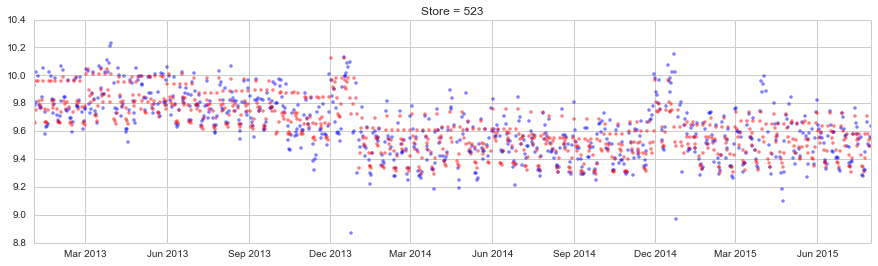

In [212]:
plotResult(models, 523)


In [234]:
#rmspes, models = trainModels(2, 'rfr', n_jobs=-1, n_estimators=100)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.141892203695
Model:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [335]:
#rmspes, models = trainModels(2, 'kr')


train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.131524680848
Model:
KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)


## Make Predictions on Test data ##

In [226]:
def makePredictions(data):
    test_ids = []
    test_yhats = []

    grouped = data.groupby('Store')

    for storeId, group in grouped:
        ids = group['Id']
        X = group[x_cols]

        yhat = np.exp(models[storeId].predict(X))

        # Ignore prediction and set Sales to zero hen the store is closed
        yhat[np.array(group['Open'] == 0)] = 0
        test_yhats += yhat.tolist()
        test_ids += ids.tolist()

    res = [[i, y] for i, y in zip(test_ids, test_yhats)]
    return sorted(res, key=lambda x: x[0])

In [237]:
result = makePredictions(test_data)

In [238]:
f = open("submission.csv", "w")
f.write('"Id","Sales"\n')

for r in result:
    f.write("%d,%d\n" % (r[0],int(r[1])))
    
f.close()


In [239]:
# Quick check to make sure the file isn't corrupted.
df = pd.read_csv('submission.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 2 columns):
Id       41088 non-null int64
Sales    41088 non-null int64
dtypes: int64(2)
memory usage: 963.0 KB


#### Misc stuff ####

In [234]:
def littleTest():
    # Test prediction using some input generated from training data
    random_idx = random.sample(train_df.index.tolist(), 100)

    try_df = train_df.loc[random_idx]
    try_y = try_df['Sales']
    #try_df.drop(['Sales', 'Customers'], axis=1, inplace=True)
    try_df["Id"] = range(1, len(try_df) + 1)
    try_data = transformData(pd.merge(try_df, store_df, on='Store'))

    result = makePredictions(try_data)
    try_yhat = np.array([r[1] for r in result])

    print rmspe(try_y, try_yhat)

In [233]:
littleTest()

KeyError: 'Id'